<div>
    <table style="border:2px solid white;" cellspacing="0" cellpadding="0" border-collapse: collapse; border-spacing: 0;>
      <tr> 
        <th style="background-color:white"> <img src="../media/ccal-logo-D3.png" width=225 height=225></th>
        <th style="background-color:white"> <img src="../media/logoMoores.jpg" width=175 height=175></th>
        <th style="background-color:white"> <img src="../media/GP.png" width=200 height=200></th>
        <th style="background-color:white"> <img src="../media/UCSD_School_of_Medicine_logo.png" width=175 height=175></th> 
        <th style="background-color:white"> <img src="../media/Broad.png" width=130 height=130></th> 
      </tr>
    </table>
</div>

<hr style="border: none; border-bottom: 3px solid #88BBEE;">

# **Onco-*GPS* Methodology**
## **Chapter 2.  Generating Oncogenic Activation Signature** 

<div>
    <img style="float: left" src="../media/authors.png" width=800 height=40>
</div>

**Date:** April 17, 2017

**Article:** [*Kim et al.* Decomposing Oncogenic Transcriptional Signatures to Generate Maps of Divergent Cellular States](https://drive.google.com/file/d/0B0MQqMWLrsA4b2RUTTAzNjFmVkk/view?usp=sharing)

**Analysis overview**

In this chapter we will execute the first step in the Onco-GPS methodology: generating the oncogenic activation signature.

<div>
    <img src="../media/method_chap1.png" width=2144 height=1041>
</div>

The Onco-GPS method makes use of a signature from an isogenic system that provides clean and direct transcriptional information relevant to the transcriptional changes associated with the activation of an oncogene; while at the same time incorporating diverse regulatory circuits inherently represented across multiple cellular contexts in a reference dataset. This deconvolves the functional consequences of oncogene activation in a more direct and unambiguous way. 

In this notebook we will generate a KRAS signature based on RNASeq profiling of lentiviral constructs of KRAS mut G12 vs. controls in lung SALE epithelial cell lines. We performed pilot experiments to identify optimal set of conditions (time, viral titer) to carry out the  experiments. This KRAS signature will contain the set of top 1,000 differentially expressed genes, (top 500, bottom 500), according to the Information Coefficient (IC).  The Information Coefficient (IC) ([*Linfoot 1957*](http://www.sciencedirect.com/science/article/pii/S001999585790116X); [*Joe 1989*](https://www.jstor.org/stable/2289859?seq=1#page_scan_tab_contents); [*Kim, J.W., Botvinnik 2016*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4868596/)) is a normalized version of the mutual information defined as,

<p>
<div>
    <img src="../media/chap2_equation1.png" width=300 height=50>
</div>

where $I(x, y)$  is the differential mutual information between $x$, the KRAS mut vs. cntrl binary phenotype, and $y$, the expression profile for each gene. This quantity  lies in the range [-1, 1], in analogy with the correlation coefficient. The sign of the correlation coefficient $\rho(x, y)$ is used to provide directionality. The differential [mutual Information](https://en.wikipedia.org/wiki/Mutual_information) $I(x, y)$  is a function of the ratio of joint and marginal probabilities, 

<div>
    <img src="../media/chap2_equation2.png" width=450 height=50>
</div>

The $H(x,y)$, $H(x)$ and $H(y)$ are the joint and marginal [entropies](https://en.wikipedia.org/wiki/Entropy_(information_theory). Estimating the mutual information between a phenotype and gene expression profiles requires the empirical approximation of continuous probability density distributions using kernel [density estimators](https://en.wikipedia.org/wiki/Density_estimation) ([*Sheather 2004*](http://www.stat.washington.edu/courses/stat527/s13/readings/Sheather_StatSci_2004.pdf)).

Go to the [next chapter (3)](3 Decomposing Signature and Defining Transcriptional Components.ipynb).
Back to the [introduction chapter (0)](0 Introduction and Overview.ipynb).

<hr style="border: none; border-bottom: 3px solid #88BBEE;">
### 1. Set up notebook and import Computational Cancer Analysis Library ([CCAL](https://github.com/KwatME/ccal))

In [1]:
from environment import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

### 2. Read gene expression dataset 

In [6]:
gene_exp = ccal.read_gct('../data/kras_isogenic_vs_imortalized.gct')

### 3. Generate oncogenic signature 
As mentioned in the introduction the signature will consist of the genes that have expression profiles that are associated, i.e. share information as estimated by the IC, with the KRAS mut vs. cntrl phenotype. 

#### 3.1 Define the KRAS mut vs. cntrl phenotype 
This is a vector of 1 and -1 indicating which samples are KRAS mut and which are controls (see [article](https://drive.google.com/file/d/0B0MQqMWLrsA4b2RUTTAzNjFmVkk/view?usp=sharing) for details).

In [7]:
target = ccal.support.d1.make_series(
    [1, 1, 1, 1, 1, 1, -1, -1, -1, -1],
    index=gene_exp.columns,
    name='KRAS mut vs. cntrl')

#### 3.2 Find top differentially expressed genes between KRAS mut vs. cntl and show them in a heatmap
This is the main function used in this notebook. It computes the association between the phenotype and the gene expression profiles as described in the introduction above. At completion this function will produce a heatmap (SIGNATURE.pdf) and a text file (SIGNATURE.txt) where the genes have been sorted by their association with the phenotype as measured by the IC. The function also computes a bootstrap confidence interval for the IC (shown in parenthesis) and the p-values and False Discovery Rates (FDR) using an empirical permutations test (using *n_permutations* times the number of genes). The heatmap below shows the 20 genes on top (UP) and at the bottom (DOWN) of the list. The gene names are on the left of the heatmap. This computation takes a few hours and therefore it is desirable to run overnight.

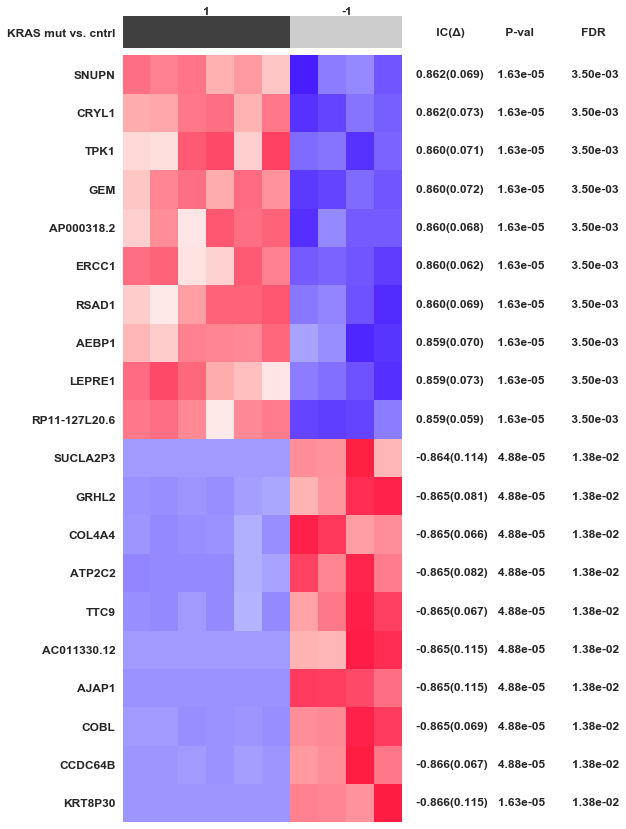

In [7]:
# Find gene scores
# It computes the association between the phenotype and the gene expression profiles as described in the introduction above.
gene_scores = ccal.association.make_association_panel(
    target=target,  # Target profile (e.g. phenotype)
    features=gene_exp,  # Data matrix with input data
    target_type='binary',  # Target profile type
    n_permutations=200,  # Number of random permutations
    filepath_prefix='../results/kras_signature',  # Output files (.txt and .pdf)
    max_n_features=20,  # Max. number of features shown in heatmap
    random_seed=12345)  # Random number generation seed

#### 3.3 Generate oncogenic signature
This computation selects the top 500 UP and bottom 500 DOWN genes

In [8]:
kras_relevant_genes = ccal.extract_top_bottom_features(gene_scores, 500, 500)

#### 3.4 Display all signature member genes in a heatmap
Make a heatmap showing the profiles of the resulting signature genes (this heatmap is shown on the left of Fig 3 in the article).

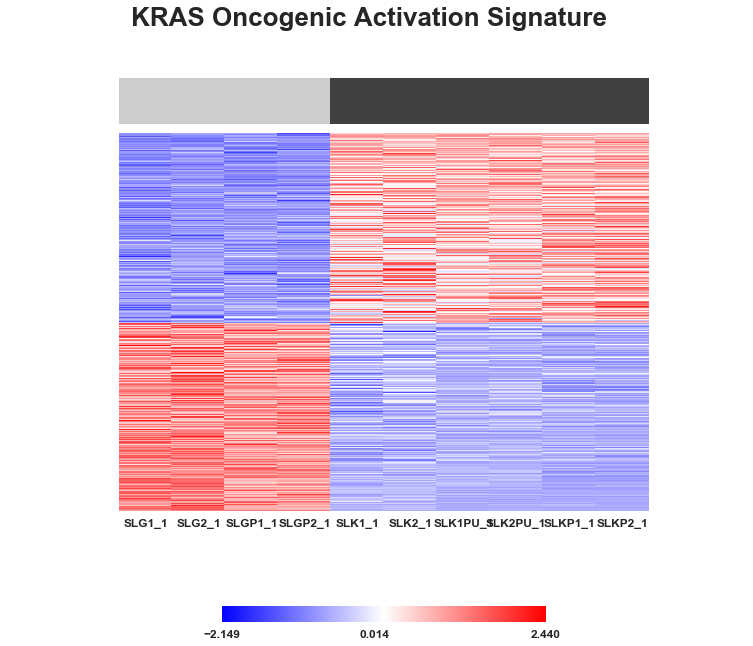

In [9]:
ccal.plot_heatmap(
    dataframe=gene_exp.ix[kras_relevant_genes, :],
    normalization_axis=1,
    normalization_method='-0-',
    column_annotation=[1, 1, 1, 1, 1, 1, -1, -1, -1, -1],
    title='KRAS Oncogenic Activation Signature')